In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ===============================
# 1. Copiar imágenes al SSD local
# ===============================
!cp -r "/content/drive/MyDrive/TESIS/MURA-v1.1/train" /content/
!cp -r "/content/drive/MyDrive/TESIS/MURA-v1.1/valid" /content/

import pandas as pd

# ===============================
# 2. Cargar CSVs desde Google Drive
# ===============================
df_train = pd.read_csv("/content/drive/MyDrive/TESIS/MURA-v1.1/train_multiclase.csv")
df_valid = pd.read_csv("/content/drive/MyDrive/TESIS/MURA-v1.1/valid_multiclase.csv")

# ===============================
# 3. Corregir rutas de imágenes
# ===============================
def corregir_ruta_local(ruta):
    ruta = str(ruta)
    for base in ["train", "valid"]:
        if base in ruta.lower():
            idx = ruta.lower().index(base)
            return f"/content/{ruta[idx:]}"
    return ruta  # Por si no encuentra nada

df_train["ruta"] = df_train["ruta"].apply(corregir_ruta_local)
df_valid["ruta"] = df_valid["ruta"].apply(corregir_ruta_local)

# ===============================
# 4. Guardar CSVs corregidos en local (temporales)
# ===============================
df_train.to_csv("/content/train_multiclase_tmp.csv", index=False)
df_valid.to_csv("/content/valid_multiclase_tmp.csv", index=False)

# ===============================
# 5. Verificar ejemplos
# ===============================
print(" Ejemplo de ruta en train:", df_train["ruta"].iloc[0])
print(" Ejemplo de ruta en valid:", df_valid["ruta"].iloc[0])
print(" Total imágenes - Train:", len(df_train), "| Valid:", len(df_valid))


 Ejemplo de ruta en train: /content/train/XR_SHOULDER/patient00001/study1_positive/image1.png
 Ejemplo de ruta en valid: /content/valid/XR_WRIST/patient11185/study1_positive/image1.png
 Total imágenes - Train: 36808 | Valid: 3197


In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.io as io
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd

# ===============================
# Configuración
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Usando {device}")

IMG_SIZE = 224
NUM_CLASSES = 14
BATCH_SIZE = 64
EPOCHS_FROZEN = 40
EPOCHS_UNFROZEN = 40
LR_FROZEN = 1e-4
LR_UNFROZEN = 1e-6
CHECKPOINT_PATH = "/content/drive/MyDrive/TESIS/MURA-v1.1/checkpoint_resnet50.pth"


# ===============================
# Transformaciones mínimas (solo resize)
# ===============================
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ConvertImageDtype(torch.float),
])

# ===============================
# Dataset desde CSV
# ===============================
class FractureDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]["ruta"]
        label = int(self.df.iloc[idx]["clase"])
        img = io.read_image(path)

        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)

        img = transform(img)
        return img, torch.tensor(label, dtype=torch.long)

# ===============================
# Datos
# ===============================

train_csv = "/content/content/train_multiclase_tmp.csv"
valid_csv = "/content/content/valid_multiclase_tmp.csv"

train_dataset = FractureDataset(train_csv)
valid_dataset = FractureDataset(valid_csv)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True)


# ===============================
# Modelo ResNet50
# ===============================
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, NUM_CLASSES)
)
model = model.to(device)

# ===============================
# Checkpoints
# ===============================
def save_checkpoint(model, optimizer, epoch, path=CHECKPOINT_PATH):
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch
    }, path)
    print(f" Checkpoint guardado (época {epoch})")

def load_checkpoint(model, optimizer, path=CHECKPOINT_PATH):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f" Checkpoint cargado desde época {checkpoint['epoch'] + 1}")
        return checkpoint["epoch"] + 1
    return 0

# ===============================
# Entrenamiento en 2 fases
# ===============================
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()

#  Fase 1: congelar base
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters(), lr=LR_FROZEN)
start_epoch = load_checkpoint(model, optimizer)

print("\n Iniciando entrenamiento...")
for epoch in range(start_epoch, EPOCHS_FROZEN + EPOCHS_UNFROZEN):

    #  Fase 2: fine-tuning
    if epoch == EPOCHS_FROZEN:
        print(" Cambiando a fase 2: fine-tuning completo")
        for param in model.parameters():
            param.requires_grad = True
        optimizer = torch.optim.Adam(model.parameters(), lr=LR_UNFROZEN)

    model.train()
    total, correct, loss_total = 0, 0, 0
    fase = "F1" if epoch < EPOCHS_FROZEN else "F2"
    loop = tqdm(train_loader, desc=f"{fase} Epoch {epoch+1}")

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        loss_total += loss.item()
        loop.set_postfix(loss=loss_total / len(train_loader), acc=correct / total)

    save_checkpoint(model, optimizer, epoch)

# ===============================
# Guardar modelo final
# ===============================
torch.save(model.state_dict(), "/content/drive/MyDrive/TESIS/MURA-v1.1/resnet50_multiclase.pth")

print("✅ Modelo final guardado como resnet50_multiclase.pth")


✅ Usando cuda


<ipython-input-10-2051390d179c>:108: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



 Iniciando entrenamiento...


F1 Epoch 1:   0%|          | 0/1151 [00:00<?, ?it/s]<ipython-input-10-2051390d179c>:138: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
F1 Epoch 1: 100%|██████████| 1151/1151 [02:37<00:00,  7.31it/s, acc=0.623, loss=1.02]


 Checkpoint guardado (época 0)


F1 Epoch 2: 100%|██████████| 1151/1151 [02:35<00:00,  7.41it/s, acc=0.692, loss=0.782]


 Checkpoint guardado (época 1)


F1 Epoch 3: 100%|██████████| 1151/1151 [02:37<00:00,  7.29it/s, acc=0.711, loss=0.725]


 Checkpoint guardado (época 2)


F1 Epoch 4: 100%|██████████| 1151/1151 [02:38<00:00,  7.28it/s, acc=0.721, loss=0.691]


 Checkpoint guardado (época 3)


F1 Epoch 5: 100%|██████████| 1151/1151 [02:38<00:00,  7.28it/s, acc=0.734, loss=0.667]


 Checkpoint guardado (época 4)


F1 Epoch 6: 100%|██████████| 1151/1151 [02:38<00:00,  7.28it/s, acc=0.739, loss=0.641]


 Checkpoint guardado (época 5)


F1 Epoch 7: 100%|██████████| 1151/1151 [02:37<00:00,  7.30it/s, acc=0.748, loss=0.626]


 Checkpoint guardado (época 6)


F1 Epoch 8: 100%|██████████| 1151/1151 [02:38<00:00,  7.28it/s, acc=0.753, loss=0.61]


 Checkpoint guardado (época 7)


F1 Epoch 9: 100%|██████████| 1151/1151 [02:34<00:00,  7.47it/s, acc=0.758, loss=0.596]


 Checkpoint guardado (época 8)


F1 Epoch 10: 100%|██████████| 1151/1151 [02:34<00:00,  7.44it/s, acc=0.764, loss=0.585]


 Checkpoint guardado (época 9)


F1 Epoch 11: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.772, loss=0.569]


 Checkpoint guardado (época 10)


F1 Epoch 12: 100%|██████████| 1151/1151 [02:34<00:00,  7.44it/s, acc=0.774, loss=0.559]


 Checkpoint guardado (época 11)


F1 Epoch 13: 100%|██████████| 1151/1151 [02:34<00:00,  7.43it/s, acc=0.779, loss=0.546]


 Checkpoint guardado (época 12)


F1 Epoch 14: 100%|██████████| 1151/1151 [02:34<00:00,  7.45it/s, acc=0.779, loss=0.544]


 Checkpoint guardado (época 13)


F1 Epoch 15: 100%|██████████| 1151/1151 [02:34<00:00,  7.47it/s, acc=0.786, loss=0.527]


 Checkpoint guardado (época 14)


F1 Epoch 16: 100%|██████████| 1151/1151 [02:34<00:00,  7.44it/s, acc=0.792, loss=0.518]


 Checkpoint guardado (época 15)


F1 Epoch 17: 100%|██████████| 1151/1151 [02:34<00:00,  7.45it/s, acc=0.794, loss=0.509]


 Checkpoint guardado (época 16)


F1 Epoch 18: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.799, loss=0.504]


 Checkpoint guardado (época 17)


F1 Epoch 19: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.798, loss=0.497]


 Checkpoint guardado (época 18)


F1 Epoch 20: 100%|██████████| 1151/1151 [02:34<00:00,  7.47it/s, acc=0.803, loss=0.491]


 Checkpoint guardado (época 19)


F1 Epoch 21: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.805, loss=0.484]


 Checkpoint guardado (época 20)


F1 Epoch 22: 100%|██████████| 1151/1151 [02:34<00:00,  7.44it/s, acc=0.809, loss=0.474]


 Checkpoint guardado (época 21)


F1 Epoch 23: 100%|██████████| 1151/1151 [02:34<00:00,  7.47it/s, acc=0.811, loss=0.468]


 Checkpoint guardado (época 22)


F1 Epoch 24: 100%|██████████| 1151/1151 [02:34<00:00,  7.44it/s, acc=0.815, loss=0.459]


 Checkpoint guardado (época 23)


F1 Epoch 25: 100%|██████████| 1151/1151 [02:35<00:00,  7.42it/s, acc=0.819, loss=0.449]


 Checkpoint guardado (época 24)


F1 Epoch 26: 100%|██████████| 1151/1151 [02:34<00:00,  7.44it/s, acc=0.823, loss=0.443]


 Checkpoint guardado (época 25)


F1 Epoch 27: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.824, loss=0.441]


 Checkpoint guardado (época 26)


F1 Epoch 28: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.822, loss=0.437]


 Checkpoint guardado (época 27)


F1 Epoch 29: 100%|██████████| 1151/1151 [02:34<00:00,  7.44it/s, acc=0.826, loss=0.434]


 Checkpoint guardado (época 28)


F1 Epoch 30: 100%|██████████| 1151/1151 [02:34<00:00,  7.43it/s, acc=0.832, loss=0.419]


 Checkpoint guardado (época 29)


F1 Epoch 31: 100%|██████████| 1151/1151 [02:35<00:00,  7.39it/s, acc=0.83, loss=0.421]


 Checkpoint guardado (época 30)


F1 Epoch 32: 100%|██████████| 1151/1151 [02:34<00:00,  7.45it/s, acc=0.836, loss=0.411]


 Checkpoint guardado (época 31)


F1 Epoch 33: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.836, loss=0.407]


 Checkpoint guardado (época 32)


F1 Epoch 34: 100%|██████████| 1151/1151 [02:34<00:00,  7.45it/s, acc=0.838, loss=0.404]


 Checkpoint guardado (época 33)


F1 Epoch 35: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.84, loss=0.402]


 Checkpoint guardado (época 34)


F1 Epoch 36: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.845, loss=0.392]


 Checkpoint guardado (época 35)


F1 Epoch 37: 100%|██████████| 1151/1151 [02:34<00:00,  7.46it/s, acc=0.843, loss=0.39]


 Checkpoint guardado (época 36)


F1 Epoch 38: 100%|██████████| 1151/1151 [02:34<00:00,  7.45it/s, acc=0.844, loss=0.391]


 Checkpoint guardado (época 37)


F1 Epoch 39: 100%|██████████| 1151/1151 [02:33<00:00,  7.48it/s, acc=0.847, loss=0.387]


 Checkpoint guardado (época 38)


F1 Epoch 40: 100%|██████████| 1151/1151 [02:34<00:00,  7.45it/s, acc=0.85, loss=0.375]


 Checkpoint guardado (época 39)
 Cambiando a fase 2: fine-tuning completo


F2 Epoch 41: 100%|██████████| 1151/1151 [03:01<00:00,  6.35it/s, acc=0.863, loss=0.348]


 Checkpoint guardado (época 40)


F2 Epoch 42: 100%|██████████| 1151/1151 [03:02<00:00,  6.32it/s, acc=0.874, loss=0.325]


 Checkpoint guardado (época 41)


F2 Epoch 43: 100%|██████████| 1151/1151 [03:02<00:00,  6.32it/s, acc=0.882, loss=0.307]


 Checkpoint guardado (época 42)


F2 Epoch 44: 100%|██████████| 1151/1151 [03:01<00:00,  6.33it/s, acc=0.887, loss=0.298]


 Checkpoint guardado (época 43)


F2 Epoch 45: 100%|██████████| 1151/1151 [03:01<00:00,  6.34it/s, acc=0.896, loss=0.279]


 Checkpoint guardado (época 44)


F2 Epoch 46: 100%|██████████| 1151/1151 [03:01<00:00,  6.33it/s, acc=0.9, loss=0.268]


 Checkpoint guardado (época 45)


F2 Epoch 47: 100%|██████████| 1151/1151 [03:01<00:00,  6.34it/s, acc=0.905, loss=0.259]


 Checkpoint guardado (época 46)


F2 Epoch 48: 100%|██████████| 1151/1151 [03:01<00:00,  6.33it/s, acc=0.912, loss=0.246]


 Checkpoint guardado (época 47)


F2 Epoch 49: 100%|██████████| 1151/1151 [03:01<00:00,  6.34it/s, acc=0.919, loss=0.234]


 Checkpoint guardado (época 48)


F2 Epoch 50: 100%|██████████| 1151/1151 [03:01<00:00,  6.35it/s, acc=0.92, loss=0.225]


 Checkpoint guardado (época 49)


F2 Epoch 51: 100%|██████████| 1151/1151 [03:05<00:00,  6.19it/s, acc=0.929, loss=0.211]


 Checkpoint guardado (época 50)


F2 Epoch 52: 100%|██████████| 1151/1151 [03:08<00:00,  6.11it/s, acc=0.931, loss=0.204]


 Checkpoint guardado (época 51)


F2 Epoch 53: 100%|██████████| 1151/1151 [03:08<00:00,  6.11it/s, acc=0.934, loss=0.196]


 Checkpoint guardado (época 52)


F2 Epoch 54: 100%|██████████| 1151/1151 [03:07<00:00,  6.13it/s, acc=0.939, loss=0.187]


 Checkpoint guardado (época 53)


F2 Epoch 55: 100%|██████████| 1151/1151 [03:07<00:00,  6.12it/s, acc=0.942, loss=0.18]


 Checkpoint guardado (época 54)


F2 Epoch 56: 100%|██████████| 1151/1151 [03:08<00:00,  6.10it/s, acc=0.947, loss=0.169]


 Checkpoint guardado (época 55)


F2 Epoch 57: 100%|██████████| 1151/1151 [03:09<00:00,  6.08it/s, acc=0.947, loss=0.166]


 Checkpoint guardado (época 56)


F2 Epoch 58: 100%|██████████| 1151/1151 [03:09<00:00,  6.08it/s, acc=0.955, loss=0.154]


 Checkpoint guardado (época 57)


F2 Epoch 59: 100%|██████████| 1151/1151 [03:08<00:00,  6.11it/s, acc=0.956, loss=0.148]


 Checkpoint guardado (época 58)


F2 Epoch 60: 100%|██████████| 1151/1151 [03:07<00:00,  6.13it/s, acc=0.957, loss=0.143]


 Checkpoint guardado (época 59)


F2 Epoch 61: 100%|██████████| 1151/1151 [03:08<00:00,  6.11it/s, acc=0.961, loss=0.135]


 Checkpoint guardado (época 60)


F2 Epoch 62: 100%|██████████| 1151/1151 [03:08<00:00,  6.11it/s, acc=0.966, loss=0.126]


 Checkpoint guardado (época 61)


F2 Epoch 63: 100%|██████████| 1151/1151 [03:08<00:00,  6.10it/s, acc=0.966, loss=0.122]


 Checkpoint guardado (época 62)


F2 Epoch 64: 100%|██████████| 1151/1151 [03:09<00:00,  6.08it/s, acc=0.969, loss=0.115]


 Checkpoint guardado (época 63)


F2 Epoch 65: 100%|██████████| 1151/1151 [03:07<00:00,  6.14it/s, acc=0.97, loss=0.111]


 Checkpoint guardado (época 64)


F2 Epoch 66: 100%|██████████| 1151/1151 [03:08<00:00,  6.12it/s, acc=0.973, loss=0.105]


 Checkpoint guardado (época 65)


F2 Epoch 67: 100%|██████████| 1151/1151 [03:08<00:00,  6.11it/s, acc=0.974, loss=0.102]


 Checkpoint guardado (época 66)


F2 Epoch 68: 100%|██████████| 1151/1151 [03:08<00:00,  6.11it/s, acc=0.975, loss=0.0966]


 Checkpoint guardado (época 67)


F2 Epoch 69: 100%|██████████| 1151/1151 [03:08<00:00,  6.09it/s, acc=0.977, loss=0.0923]


 Checkpoint guardado (época 68)


F2 Epoch 70: 100%|██████████| 1151/1151 [03:09<00:00,  6.09it/s, acc=0.979, loss=0.0876]


 Checkpoint guardado (época 69)


F2 Epoch 71: 100%|██████████| 1151/1151 [03:08<00:00,  6.10it/s, acc=0.98, loss=0.0823]


 Checkpoint guardado (época 70)


F2 Epoch 72: 100%|██████████| 1151/1151 [03:08<00:00,  6.12it/s, acc=0.983, loss=0.077]


 Checkpoint guardado (época 71)


F2 Epoch 73: 100%|██████████| 1151/1151 [03:08<00:00,  6.12it/s, acc=0.983, loss=0.0753]


 Checkpoint guardado (época 72)


F2 Epoch 74: 100%|██████████| 1151/1151 [03:07<00:00,  6.13it/s, acc=0.985, loss=0.0693]


 Checkpoint guardado (época 73)


F2 Epoch 75: 100%|██████████| 1151/1151 [03:07<00:00,  6.12it/s, acc=0.987, loss=0.0671]


 Checkpoint guardado (época 74)


F2 Epoch 76: 100%|██████████| 1151/1151 [03:08<00:00,  6.12it/s, acc=0.988, loss=0.0635]


 Checkpoint guardado (época 75)


F2 Epoch 77: 100%|██████████| 1151/1151 [03:08<00:00,  6.10it/s, acc=0.988, loss=0.0618]


 Checkpoint guardado (época 76)


F2 Epoch 78: 100%|██████████| 1151/1151 [03:08<00:00,  6.10it/s, acc=0.988, loss=0.0569]


 Checkpoint guardado (época 77)


F2 Epoch 79: 100%|██████████| 1151/1151 [03:06<00:00,  6.16it/s, acc=0.989, loss=0.0555]


 Checkpoint guardado (época 78)


F2 Epoch 80: 100%|██████████| 1151/1151 [03:01<00:00,  6.33it/s, acc=0.99, loss=0.0517]


 Checkpoint guardado (época 79)
✅ Modelo final guardado como resnet50_multiclase.pth


**PREDICIONES**

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar ResNet50 con el mismo head
model = models.resnet50()
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 14)  # 14 clases
)
model.load_state_dict(torch.load("/content/drive/MyDrive/TESIS/MURA-v1.1/resnet50_multiclase.pth", map_location=device))
model = model.to(device)
model.eval()

print("✅ Modelo cargado y listo para predicción")


✅ Modelo cargado y listo para predicción


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display

NUM_CLASSES = 14
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]

report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# Convertir a DataFrame y redondear
df_metrics = pd.DataFrame(report_dict).transpose().round(3)

# Mostrar en consola como tabla completa
print("📋 Reporte de Clasificación:")
print(df_metrics.to_string())

# Mostrar como tabla interactiva
print("\n📊 Vista interactiva en notebook:")
display(df_metrics)

# Guardar a CSV y Excel
df_metrics.to_csv("/content/metricas_clasificacion.csv")
df_metrics.to_excel("/content/metricas_clasificacion.xlsx")

print(" Métricas guardadas en:")
print("   - /content/metricas_clasificacion.csv")
print("   - /content/metricas_clasificacion.xlsx")


📋 Reporte de Clasificación:
              precision  recall  f1-score   support
Clase 0           0.702   0.702     0.702   285.000
Clase 1           0.678   0.719     0.698   278.000
Clase 2           0.705   0.813     0.755   235.000
Clase 3           0.727   0.683     0.704   230.000
Clase 4           0.651   0.794     0.716   214.000
Clase 5           0.807   0.611     0.696   247.000
Clase 6           0.713   0.780     0.745   150.000
Clase 7           0.725   0.490     0.585   151.000
Clase 8           0.674   0.945     0.786   271.000
Clase 9           0.794   0.407     0.538   189.000
Clase 10          0.799   0.750     0.774   148.000
Clase 11          0.810   0.729     0.767   140.000
Clase 12          0.769   0.868     0.815   364.000
Clase 13          0.779   0.695     0.735   295.000
accuracy          0.728   0.728     0.728     0.728
macro avg         0.738   0.713     0.715  3197.000
weighted avg      0.735   0.728     0.722  3197.000

📊 Vista interactiva en notebook:


,precision,recall,f1-score,support
Clase 0,0.702,0.702,0.702,285.000
Clase 1,0.678,0.719,0.698,278.000
Clase 2,0.705,0.813,0.755,235.000
Clase 3,0.727,0.683,0.704,230.000
Clase 4,0.651,0.794,0.716,214.000
Clase 5,0.807,0.611,0.696,247.000
Clase 6,0.713,0.780,0.745,150.000
Clase 7,0.725,0.490,0.585,151.000
Clase 8,0.674,0.945,0.786,271.000
Clase 9,0.794,0.407,0.538,189.000


 Métricas guardadas en:
   - /content/metricas_clasificacion.csv
   - /content/metricas_clasificacion.xlsx


CURVA ROC EN FORMATO CSV

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np


# Binarizar etiquetas reales
y_true_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
y_score = np.array(all_probs)

# Calcular AUC por clase
auc_scores = {}
for i in range(NUM_CLASSES):
    try:
        auc_val = roc_auc_score(y_true_bin[:, i], y_score[:, i])
    except ValueError:
        auc_val = None  # Si hay clases sin ejemplos
    auc_scores[class_names[i]] = auc_val

# Convertir a DataFrame y guardar
df_auc = pd.DataFrame.from_dict(auc_scores, orient="index", columns=["AUC"])
df_auc.index.name = "Clase"
df_auc.to_csv("/content/auc_por_clase.csv")
print("AUC por clase guardado en auc_por_clase.csv")


AUC por clase guardado en auc_por_clase.csv


CURVA ROC EN FORMATO DE IMÁGEN

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
import os

# Configuraciones
NUM_CLASSES = 14
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]
save_path = "/content/curvas_roc_clases"

# Crear carpeta si no existe
os.makedirs(save_path, exist_ok=True)

# Binarizar etiquetas reales
y_true_bin = label_binarize(all_labels, classes=list(range(NUM_CLASSES)))
y_score = np.array(all_probs)

# Una curva por clase
for i in range(NUM_CLASSES):
    try:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.4f}")
        plt.plot([0, 1], [0, 1], "k--", lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("Tasa de Falsos Positivos (FPR)")
        plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
        plt.title(f"📈 Curva ROC - {class_names[i]}")
        plt.legend(loc="lower right")
        plt.grid(True)

        # Guardar curva
        file_path = os.path.join(save_path, f"roc_clase_{i}.png")
        plt.savefig(file_path)
        plt.close()
        print(f"✅ Guardada curva ROC: {file_path}")

    except ValueError:
        print(f"⚠️ No se pudo calcular curva ROC para {class_names[i]} (clase vacía)")


<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_0.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_1.png


<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_2.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_3.png


<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_4.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_5.png


<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_6.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_7.png


<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_8.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_9.png


<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_10.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_11.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_12.png
✅ Guardada curva ROC: /content/curvas_roc_clases/roc_clase_13.png


<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)
<ipython-input-17-75bc0d35e7a6>:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig(file_path)


<ipython-input-18-0869200a8519>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


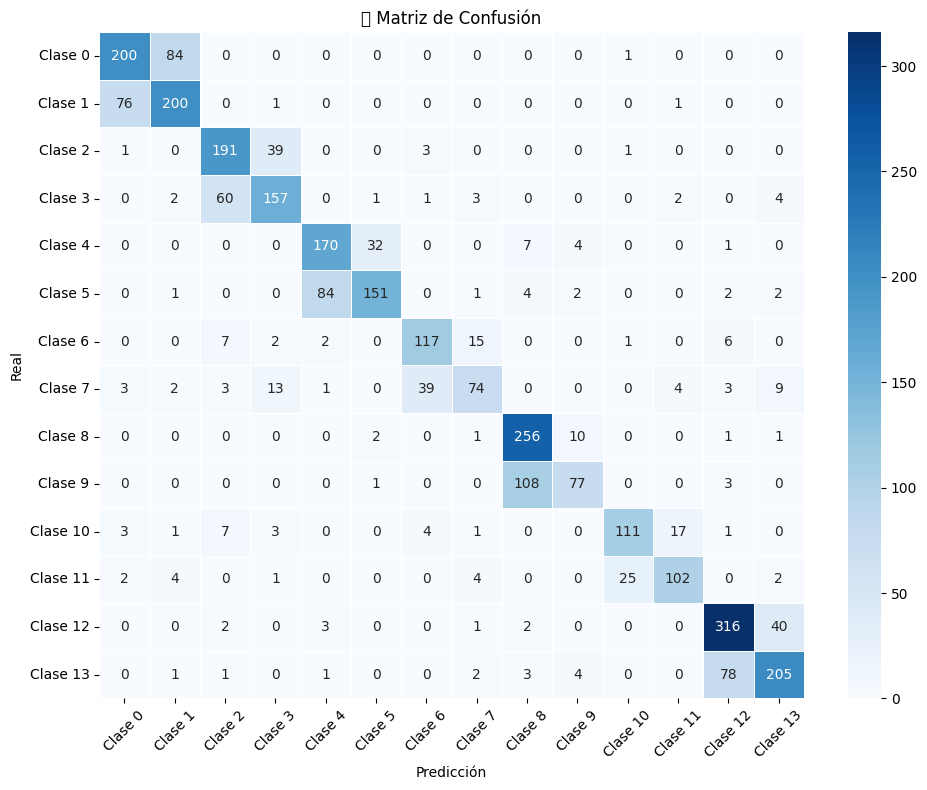

✅ Matriz de confusión guardada como matriz_confusion.csv


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# 2. Crear etiquetas si no las tenés
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]

# 3. Convertir a DataFrame para visualización y guardado
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.index.name = "Real"
df_cm.columns.name = "Predicho"

# 4. Mostrar visualmente la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("📊 Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Guardar como CSV
df_cm.to_csv("/content/matriz_confusion.csv")
print("✅ Matriz de confusión guardada como matriz_confusion.csv")
